# Default Risk and Income Fluctuations

----

#### John Stachurski
#### Prepared for the CBC Computational Workshop (May 2024)

----

Uncomment if necessary:

In [1]:
#!pip install quantecon

## Overview

This lecture studies [Arellano’s 2008 model of sovereign default](https://www.aeaweb.org/articles?id=10.1257/aer.98.3.690).

The model describes interactions among default risk, output, and an
equilibrium interest rate that includes a premium for endogenous default risk.

The decision maker is a government of a small open economy that borrows from
risk-neutral foreign creditors.

The foreign lenders must be compensated for default risk.

The government borrows and lends abroad in order to smooth the consumption of
its citizens.

The government repays its debt only if it wants to, but declining to pay has
adverse consequences.

The interest rate on government debt adjusts in response to the
state-dependent default probability chosen by government.

Let’s start with some imports:

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import random
import jax
import jax.numpy as jnp
from collections import namedtuple

We will use 64 bit floats with JAX in order to increase the precision.

In [3]:
jax.config.update("jax_enable_x64", True)

## Structure

In this section we describe the main features of the model.

### Output, Consumption and Debt

A small open economy is endowed with an exogenous stochastically fluctuating 
potential output stream $ \{y_t\} $.

Potential output is realized only in periods in which the government honors its sovereign debt.

The output good can be traded or consumed.

The sequence $ \{y_t\} $ is described by a Markov process with stochastic density kernel
$ p(y, y') $.

Households within the country are identical and rank stochastic consumption streams according to

$$
 \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$ 

Here

- $ 0 < \beta < 1 $ is a time discount factor
- $ u $ is an increasing and strictly concave utility function


The government  aims to maximize household utility.

### Asset Markets

When the government is not excluded from financial markets, the one-period 
national budget constraint is

$$
c + q B' = y + B 
$$ 

Here and below, a prime denotes a next period value.

To rule out Ponzi schemes, we also require that $ B \geq -Z $ in every period.

- $ Z $ is chosen to be sufficiently large that the constraint never binds in equilibrium.


Foreign creditors are risk neutral.

Their discount rate is

$$
q = \frac{1 - \delta}{1 + r}
$$

### Government’s Decisions

At each point in time $ t $, the government chooses between defaulting and meeting its current obligations

If the government defaults in the current period, then consumption equals current output.

Moreover,

1. Output immediately falls from $ y $ to $ h(y) $, where $ 0 \leq h(y) \leq y $.
      - It returns to $ y $ only after the country regains access to international credit
    markets.
1. The country loses access to foreign credit markets.

While in a state of default, the economy regains access to foreign credit 
in each subsequent period with probability $ \theta $.

## Equilibrium

The value of defaulting is

$$
v_d(y) = u(h(y)) +
            \beta \int \left\{
            \theta v(0, y') + (1 - \theta) v_d(y')
            \right\}
            p(y, y') dy'
$$

The value of paying is

$$
v_c(B, y) = \max_{B' \geq -Z}
       \left\{
            u(y - q(B', y) B' + B) +
            \beta \int v(B', y') p(y, y') dy'
      \right\}
$$

The three value functions are linked by

$$
v(B, y) = \max\{ v_c(B, y), v_d(y) \}
$$

The government chooses to default when

$$
v_c(B, y) < v_d(y)
$$

and hence given $ B' $ the probability of default next period is

$$
\delta(B', y) := \int \mathbb 1\{v_c(B', y') < v_d(y') \} p(y, y') dy'
$$ 

Given zero profits for foreign creditors in equilibrium,  the bond price function is

$$
q(B', y) = \frac{1 - \delta(B', y)}{1 + r}
$$

### Definition of Equilibrium

An *equilibrium* is

- a pricing function $ q(B',y) $,
- a triple of value functions $ (v_c(B, y), v_d(y), v(B,y)) $,
- a decision rule telling the government when to default and when to pay as 
  a function of the state $ (B, y) $, and
- an asset accumulation rule that, conditional on choosing not to default, 
  maps $ (B,y) $ into $ B' $


such that

1. The three Bellman equations for $ (v_c(B, y), v_d(y), v(B,y)) $ are satisfied
1. Given the price function $ q(B',y) $, the default decision rule and the asset 
  accumulation decision rule attain the optimal value function  $ v(B,y) $

## Computation

Let’s now compute an equilibrium of Arellano’s model.

The equilibrium objects are the value function $ v(B, y) $, the associated
default decision rule, and the pricing function $ q(B', y) $.



We use a slightly modified version of the algorithm recommended by Arellano.

- Arellano recommends value function iteration until convergence, updating the price, and then repeating.
- Instead, we update the bond price at every value function iteration step.

The second approach is faster and the two different procedures deliver similar results.

We define a namedtuple to store parameters, grids and transition
probabilities.

In [4]:
ArellanoEconomy = namedtuple('ArellanoEconomy',
    ('β',     # Time discount parameter
    'γ',      # Utility parameter
    'r',      # Lending rate
    'ρ',      # Persistence in the income process
    'η',      # Standard deviation of the income process
    'θ',      # Prob of re-entering financial markets
    'P',      # Markov matrix governing the income process
    'B_grid', # Bond unit grid
    'y_grid', # State values of the income process 
    'def_y')) # Default income process

In [5]:
def create_arellano_model(
    B_size=251,         # Grid size for bonds
    B_min=-0.45,        # Smallest B value
    B_max=0.45,         # Largest B value
    y_size=51,          # Grid size for income
    β=0.953,            # Time discount parameter
    γ=2.0,              # Utility parameter
    r=0.017,            # Lending rate
    ρ=0.945,            # Persistence in the income process
    η=0.025,            # Standard deviation of the income process
    θ=0.282,            # Prob of re-entering financial markets
    def_y_param=0.969): # Parameter governing income in default

    # Set up grids
    B_grid = jnp.linspace(B_min, B_max, B_size)
    mc = qe.markov.tauchen(y_size, ρ, η)
    y_grid, P = jnp.exp(mc.state_values), jnp.array(mc.P)
    # Output received while in default, with same shape as y_grid
    def_y = jnp.minimum(def_y_param * jnp.mean(y_grid), y_grid)
    
    return ArellanoEconomy(β=β, γ=γ, r=r, ρ=ρ, η=η, θ=θ, 
                           P=P, B_grid=B_grid, y_grid=y_grid, def_y=def_y)

Here is the utility function.

In [6]:
@jax.jit
def u(c, γ):
    return c**(1-γ)/(1-γ)

Here is a function to compute the bond price at each state, given $ v_c $ and
$ v_d $.

In [7]:
@jax.jit
def compute_q(v_c, v_d, model):
    """
    Compute the bond price function q(B, y) at each (B, y) pair.  The first
    step is to calculate the default probabilities

        δ(B, y) := Σ_{y'} 1{v_c(B, y') < v_d(y')} P(y, y') dy'

    """

    # Unpack
    β, γ, r, ρ, η, θ, P, B_grid, y_grid, def_y = model
    B_size, y_size = len(B_grid), len(y_grid)

    # Set up arrays with indices [i_B, i_y, i_yp]
    v_d = jnp.reshape(v_d, (1, 1, y_size))
    v_c = jnp.reshape(v_c, (B_size, 1, y_size))
    P = jnp.reshape(P, (1, y_size, y_size))

    # Compute δ[i_B, i_y]
    default_states = v_c < v_d
    delta = jnp.sum(default_states * P, axis=(-1,))

    q = (1 - delta ) / (1 + r)
    return q

Next we introduce Bellman operators that updated $ v_d $ and $ v_c $.

In [8]:
@jax.jit
def T_d(v_c, v_d, model):
    """
    The RHS of the Bellman equation when income is at index y_idx and
    the country has chosen to default.  Returns an update of v_d.
    """
    # Unpack
    β, γ, r, ρ, η, θ, P, B_grid, y_grid, def_y = model
    B_size, y_size = len(B_grid), len(y_grid)

    B0_idx = jnp.searchsorted(B_grid, 1e-10)  # Index at which B is near zero

    current_utility = u(def_y, γ)
    v = jnp.maximum(v_c[B0_idx, :], v_d)
    w = θ * v + (1 - θ) * v_d
    A = jnp.reshape(w, (1, y_size))
    cont_value = jnp.sum(A * P, axis=(1,))

    return current_utility + β * cont_value

In [9]:
@jax.jit
def bellman(v_c, v_d, q, model):
    """
    The RHS of the Bellman equation when the country is not in a
    defaulted state on their debt.  That is,

        bellman(B, y) =
            u(y - q(B', y) B' + B) + β Σ_{y'} v(B', y') P(y, y')

    If consumption is not positive then returns -np.inf
    """
    # Unpack
    β, γ, r, ρ, η, θ, P, B_grid, y_grid, def_y = model
    B_size, y_size = len(B_grid), len(y_grid)

    # Set up c[i_B, i_y, i_Bp]
    y_idx = jnp.reshape(jnp.arange(y_size), (1, y_size, 1))
    B_idx = jnp.reshape(jnp.arange(B_size), (B_size, 1, 1))
    Bp_idx = jnp.reshape(jnp.arange(B_size), (1, 1, B_size))
    c = y_grid[y_idx] - q[Bp_idx, y_idx] * B_grid[Bp_idx] + B_grid[B_idx]

    # Set up v[i_B, i_y, i_Bp, i_yp] and P[i_B, i_y, i_Bp, i_yp]
    v_d = jnp.reshape(v_d, (1, 1, 1, y_size))
    v_c = jnp.reshape(v_c, (1, 1, B_size, y_size))
    v = jnp.maximum(v_c, v_d)
    P = jnp.reshape(P, (1, y_size, 1, y_size))
    # Sum over i_yp
    continuation_value = jnp.sum(v * P, axis=(3,))

    # Return new_v_c[i_B, i_y, i_Bp]
    val = jnp.where(c > 0, u(c, γ) + β * continuation_value, -jnp.inf)
    return val

In [10]:
@jax.jit
def T_c(v_c, v_d, q, model):
    vals = bellman(v_c, v_d, q, model)
    return jnp.max(vals, axis=2)

In [11]:
@jax.jit
def get_greedy(v_c, v_d, q, model):
    vals = bellman(v_c, v_d, q, model)
    return jnp.argmax(vals, axis=2)

Here is a function that calls these operators in the right sequence.

In [12]:
def update_values_and_prices(v_c, v_d, model):

    q = compute_q(v_c, v_d, model)
    new_v_d = T_d(v_c, v_d, model)
    new_v_c = T_c(v_c, v_d, q, model)

    return new_v_c, new_v_d

Here's a function to solve the model.

In [13]:
def solve(model, tol=1e-8, max_iter=10_000):

    # Unpack
    β, γ, r, ρ, η, θ, P, B_grid, y_grid, def_y = model
    B_size, y_size = len(B_grid), len(y_grid)

    # Initial conditions for v_c and v_d
    v_c = jnp.zeros((B_size, y_size))
    v_d = jnp.zeros((y_size,))

    current_iter = 0
    error = tol + 1
    while (current_iter < max_iter) and (error > tol):
        if current_iter % 100 == 0:
            print(f"Entering iteration {current_iter} with error {error}.")
        new_v_c, new_v_d = update_values_and_prices(v_c, v_d, model)
        error = jnp.max(jnp.abs(new_v_c - v_c)) + jnp.max(jnp.abs(new_v_d - v_d))
        v_c, v_d = new_v_c, new_v_d
        current_iter += 1

    print(f"Terminating at iteration {current_iter}.")

    q = compute_q(v_c, v_d, model)
    B_star = get_greedy(v_c, v_d, q, model)
    return v_c, v_d, q, B_star

Let's try solving the model.

In [14]:
model = create_arellano_model()

In [15]:
v_c, v_d, q, B_star = solve(model)

Entering iteration 0 with error 1.00000001.
Entering iteration 100 with error 0.017499341639204857.
Entering iteration 200 with error 0.00014189363558969603.
Entering iteration 300 with error 1.151467966309383e-06.
Terminating at iteration 399.


In [16]:
%%time
v_c, v_d, q, B_star = solve(model)

Entering iteration 0 with error 1.00000001.
Entering iteration 100 with error 0.017499341639204857.
Entering iteration 200 with error 0.00014189363558969603.
Entering iteration 300 with error 1.151467966309383e-06.
Terminating at iteration 399.
CPU times: user 887 ms, sys: 202 ms, total: 1.09 s
Wall time: 1.04 s


## Results

Let’s try to replicate the results obtained in Arellano (2008).

In what follows, all results are computed using parameter values of `ArellanoEconomy` created by `create_arellano_model`.

For example, `r=0.017` matches the average quarterly rate on a 5 year US treasury over the period 1983–2001.

We compute the value function, policy and equilibrium prices:

In [17]:
model = create_arellano_model()

β, γ, r, ρ, η, θ, P, B_grid, y_grid, def_y = model
B_size, y_size = len(B_grid), len(y_grid)

In [18]:
v_c, v_d, q, B_star = solve(model)

Entering iteration 0 with error 1.00000001.
Entering iteration 100 with error 0.017499341639204857.
Entering iteration 200 with error 0.00014189363558969603.
Entering iteration 300 with error 1.151467966309383e-06.
Terminating at iteration 399.


The following bond price schedule replicates Figure 3 of
Arellano (2008), where $ y_L $ and $ Y_H $ are particular below average and above average
values of output $ y $.

- $ y_L $ is 5% below the mean of the $ y $ grid values
- $ y_H $ is 5% above  the mean of the $ y $ grid values

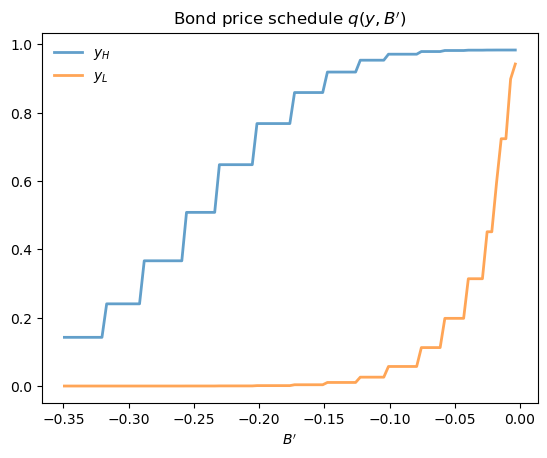

In [19]:
high, low = jnp.mean(y_grid) * 1.05, jnp.mean(y_grid) * .95
iy_high, iy_low = (jnp.searchsorted(y_grid, x) for x in (high, low))

fig, ax = plt.subplots()
ax.set_title("Bond price schedule $q(y, B')$")
# Extract a suitable plot grid
x = []
q_low = []
q_high = []
for i, B in enumerate(B_grid):
    if -0.35 <= B <= 0:  # To match fig 3 of Arellano (2008)
        x.append(B)
        q_low.append(q[i, iy_low])
        q_high.append(q[i, iy_high])
ax.plot(x, q_high, label="$y_H$", lw=2, alpha=0.7)
ax.plot(x, q_low, label="$y_L$", lw=2, alpha=0.7)
ax.set_xlabel("$B'$")
ax.legend(loc='upper left', frameon=False)
plt.show()
# -

The grid used to compute this figure was relatively fine (`y_size, B_size = 51, 251`), 
which explains the minor differences between this and Arellano’s figure.

The figure shows that

- Higher levels of debt (larger $ -B' $) induce larger discounts on the face value, which
  correspond to higher interest rates.
- Lower income also causes more discounting, as foreign creditors anticipate greater likelihood
  of default.


The next figure plots value functions and replicates the right hand panel of Figure 4 of {cite}`Are08`.

In [20]:
v = jnp.maximum(v_c, jnp.reshape(v_d, (1, y_size)))

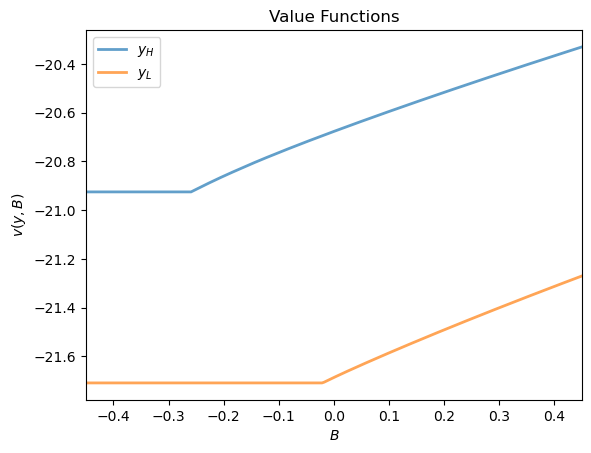

In [21]:
fig, ax = plt.subplots()
ax.set_title("Value Functions")
ax.plot(B_grid, v[:, iy_high], label="$y_H$", lw=2, alpha=0.7)
ax.plot(B_grid, v[:, iy_low], label="$y_L$", lw=2, alpha=0.7)
ax.legend(loc='upper left')
ax.set(xlabel="$B$", ylabel="$v(y, B)$")
ax.set_xlim(min(B_grid), max(B_grid))
plt.show()
# -

We can use the results of the computation to study the default probability $ \delta(B', y) $

The next plot shows these default probabilities over $ (B', y) $ as a heat map.

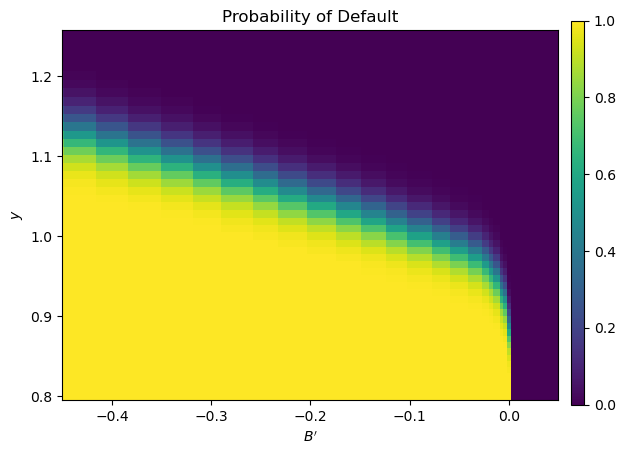

In [22]:
# Set up arrays with indices [i_B, i_y, i_yp]
shaped_v_d = jnp.reshape(v_d, (1, 1, y_size))
shaped_v_c = jnp.reshape(v_c, (B_size, 1, y_size))
shaped_P = jnp.reshape(P, (1, y_size, y_size))

# Compute delta[i_B, i_y]
default_states = 1.0 * (shaped_v_c < shaped_v_d)
delta = jnp.sum(default_states * shaped_P, axis=(2,))

# Create figure
fig, ax = plt.subplots()
hm = ax.pcolormesh(B_grid, y_grid, delta.T)
cax = fig.add_axes([.92, .1, .02, .8])
fig.colorbar(hm, cax=cax)
ax.axis([B_grid.min(), 0.05, y_grid.min(), y_grid.max()])
ax.set(xlabel="$B'$", ylabel="$y$", title="Probability of Default")
plt.show()
# -

As anticipated, the probability that the government chooses to default in the following period
increases with indebtedness and falls with income.
